In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt
import torch

from learning import lstd, valuefunc, trajdata
from env import linearenv, controller
from exputils import relerr, moving_sum, viztraj3D, load_datasets, rostraj2aug
from trajgen import quadratic, nonlinear, quadrotor

## Load trajectory from files

In [3]:
# Parameters
Tref = 300
gamma = 0.99

In [26]:
# Data from Lissajous tracking
mj1 = (np.loadtxt('rostraj/actual14dim_minjerk1'),
       np.loadtxt('rostraj/ref14dim_minjerk1'),
       np.loadtxt('rostraj/input14dim_minjerk1'))

mj2 = (np.loadtxt('rostraj/actual14dim_minjerk2'),
       np.loadtxt('rostraj/ref14dim_minjerk2'),
       np.loadtxt('rostraj/input14dim_minjerk2'))

ls1 = (np.loadtxt('rostraj/actual_lissajous14dim'),
       np.loadtxt('rostraj/ref_lissajous14dim'),
       np.loadtxt('rostraj/input_lissajous14dim'))

In [89]:
xtraj, xtraj_, utraj, rtraj, vtraj = load_datasets([mj1, mj2, ls1], Tref, gamma)

<IPython.core.display.Javascript object>


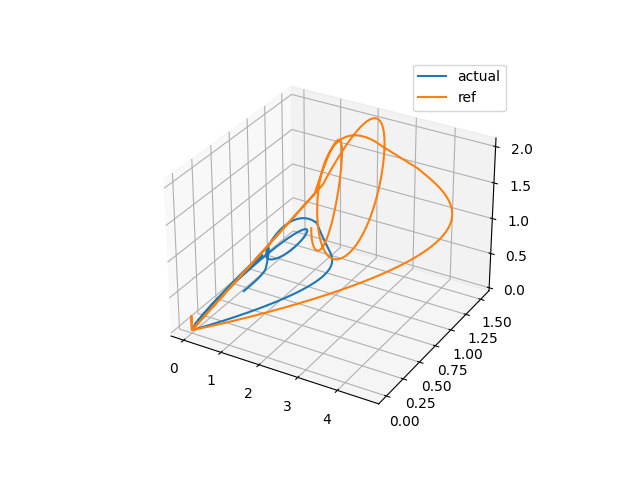

In [91]:
# Visualize trajectory
tt1 = 0
tt2 = 2000
viztraj3D([xtraj[tt1:tt2:,:3].T, xtraj[tt1:tt2:,14:17].T],['actual', 'ref'])

In [32]:
%matplotlib notebook

## Train NNs

In [94]:
# Construct a dataset of transitions
TT = -1
dataset = trajdata.TrajDataset(xtraj[:TT], utraj[:TT], rtraj[:TT], xtraj_[:TT], vtraj[:TT])
dataset.cuda()

In [95]:
# Create a network
icnnvalue = valuefunc.ICNNValueFunc(xtraj.shape[1], [100, 100, 1])
icnnvalue.cuda()

# Train the network on (x,y,z) data and see how it behaves
gamma = 0.99
icnnvalue.learn(dataset, gamma, num_epoch=1000, batch_size=64, verbose=True,
                print_interval=10, lr=0.0005, beta=0.7)

Epoch: 1 	 Training loss: 22405.78931751471
Epoch: 11 	 Training loss: 230.8026041349124
Epoch: 21 	 Training loss: 88.39031910014279
Epoch: 31 	 Training loss: 94.86607723147434
Epoch: 41 	 Training loss: 155.14721686691266
Epoch: 51 	 Training loss: 109.31327525538664
Epoch: 61 	 Training loss: 91.05780653914087
Epoch: 71 	 Training loss: 103.57358563255517
Epoch: 81 	 Training loss: 92.00665742159143
Epoch: 91 	 Training loss: 43.093421500969
Epoch: 101 	 Training loss: 66.19471516384974
Epoch: 111 	 Training loss: 135.3971580645794
Epoch: 121 	 Training loss: 40.57854504344174
Epoch: 131 	 Training loss: 41.74417964539951
Epoch: 141 	 Training loss: 41.468725694547864
Epoch: 151 	 Training loss: 25.53115361249468
Epoch: 161 	 Training loss: 55.56472096761623
Epoch: 171 	 Training loss: 33.546712928667645
Epoch: 181 	 Training loss: 28.65691596130025
Epoch: 191 	 Training loss: 43.912862946785374
Epoch: 201 	 Training loss: 39.88239269129911
Epoch: 211 	 Training loss: 22.5885371134

In [ ]:
# Create a network
mlpvalue = valuefunc.MLPValueFunc(xtraj.shape[1], [50, 50, 1])
mlpvalue.cuda()

# Train the network on (x,y,z) data and see how it behaves
gamma = 0.99
mlpvalue.learn(dataset, gamma, num_epoch=1000, batch_size=64, verbose=True,
               print_interval=10, lr=0.0005, beta=1)

Epoch: 1 	 Training loss: 119.25171302066876
Epoch: 11 	 Training loss: 63.92669275984302
Epoch: 21 	 Training loss: 44.01988838060244
Epoch: 31 	 Training loss: 25.164529818263297
Epoch: 41 	 Training loss: 21.61666977731724
Epoch: 51 	 Training loss: 18.426991805122682
Epoch: 61 	 Training loss: 18.305970138193683
Epoch: 71 	 Training loss: 16.360344937861665
Epoch: 81 	 Training loss: 15.608023214943879
Epoch: 91 	 Training loss: 16.099207652089927
Epoch: 101 	 Training loss: 18.013121579169496
Epoch: 111 	 Training loss: 15.885721927779477
Epoch: 121 	 Training loss: 14.62601194121425
Epoch: 131 	 Training loss: 14.695590093282043


In [79]:
icnnvalue.cpu()
mlpvalue.cpu()

In [86]:
#torch.save(icnnvalue, '???.pt')

## Test whether NNs learned

In [80]:
def moving_sum(x, window_size, gamma=1):
    conv = np.convolve(x, gamma ** np.arange(window_size-1, -1, -1))
    return conv[window_size-1:-window_size+1]

In [106]:
%matplotlib notebook

<IPython.core.display.Javascript object>


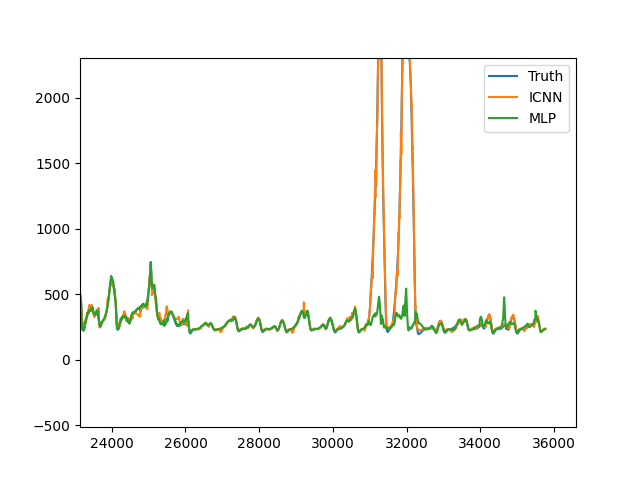

In [85]:
# Test whether NNs memorized the training data
Tstart = 0
Tend = TT
test_x = xtraj[Tstart:Tend]
test_cost = rtraj[:, 0]

# Compute the true values
true_values = moving_sum(test_cost, Tref, gamma)
plt.plot(true_values, label='Truth')

# Compute the cost from NN
icnn_values = icnnvalue.network(torch.tensor(xtraj[Tstart:Tend]))[:,0].detach()
plt.plot(icnn_values, label='ICNN')
mlp_values = mlpvalue.network(torch.tensor(xtraj[Tstart:Tend]))[:,0].detach()
plt.plot(mlp_values, label='MLP')
plt.legend()

<IPython.core.display.Javascript object>


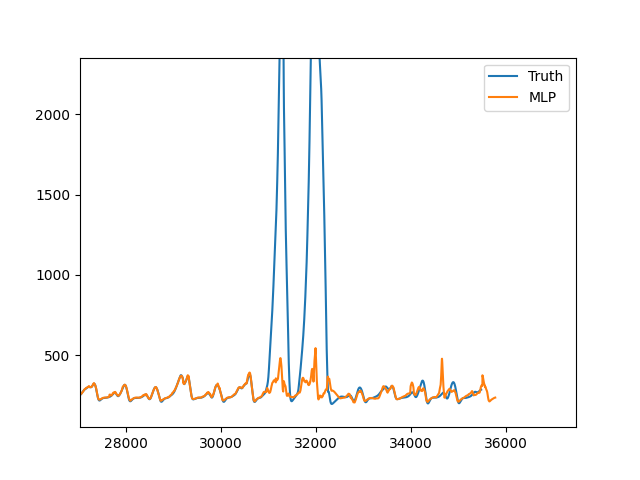

In [70]:
# Test whether NNs can generalized to unseen trajectories
Tstart = 0
Tend = 40000
test_x = xtraj[Tstart:Tend]
test_cost = rtraj[Tstart:Tend+Tref, 0]

# Compute the true values
true_values = moving_sum(test_cost, Tref, gamma)
plt.plot(true_values, label='Truth')

# Compute the cost from NN
mlp_values = mlpvalue.network(torch.tensor(xtraj[Tstart:Tend]))[:,0].detach()
plt.plot(mlp_values, label='MLP')
plt.legend()

## Generate trajectory

In [ ]:
# Generate trajectory on only x,y,z
segments = 2
waypoints = np.random.randn(4, segments+1)
ts = np.linspace(0,1,segments+1) * 2

In [ ]:
rho = 10
order = 6

_, minjerk_coeffs = quadratic.generate(waypoints.T, ts, order, Tref, 4, None, 0)
nn_coeff = quadrotor.generate(torch.tensor(waypoints), ts, order, Tref, 4, rho, mlpvalue, torch.tensor(minjerk_coeffs),
                   num_iter=10, lr=0.01)

In [ ]:
t, fullmj_traj = quadrotor.coeff2traj(minjerk_coeffs, ts, 1000)
t, fullnn_traj = quadrotor.coeff2traj(nn_coeff, ts, 1000)

In [ ]:
plt.scatter(ts, waypoints[2])
plt.plot(t, fullmj_traj[2], label='min jerk')
plt.plot(t, fullnn_traj[2], label='ours')
plt.plot(t, np.zeros(1000), 'r--')
plt.legend()

In [ ]:
dim = 13
plt.plot(t, fullmj_traj[dim], label='minjerk')
plt.plot(t, fullnn_traj[dim], label='nn')
plt.legend()

In [ ]:
# Visualize trajectory
viztraj3D([mj_traj, nn_traj], ['Min jerk', 'Dyn Reg'], waypoints)

In [ ]:
minjerk_coeffs[0]

In [ ]:
from trajgen import trajutils

In [ ]:
trajutils._diff_coeff(order, 1, dx_order) @ minjerk_coeffs[0,2]

## Debug

In [ ]:
from trajgen import quadrotor

In [ ]:
ts = [0, 1, 2]
#waypoints = np.random.random((4,len(ts)))
waypoints = np.array([[0,0,0,0], [1,1,1,1],[0,0,0,0]])
order = 7
Tref = 100

In [ ]:
waypoints.shape

In [ ]:
vmax = 5
amax = 4
traj, coeffs = quadrotor.generate(waypoints, ts, order, Tref, waypoints.shape[0], vmax, amax)

In [ ]:
xyz = 0

plt.figure(figsize=(10,5))
titles = [r'$y$', r'$\dot{y}$', r'$\ddot{y}$', r'$\dddot{y}$']
for dx_order in range(4):
    plt.subplot(1,4,dx_order+1)
    deriv_traj = []
    for t in np.linspace(0,2,100):
        if t <=1:
            deriv_traj.append( trajutils._diff_coeff(order, t, dx_order) @ coeffs[xyz, 0] )
        else:
            deriv_traj.append( trajutils._diff_coeff(order, t-1, dx_order) @ coeffs[xyz, 1])

    plt.plot(np.arange(Tref), traj[xyz::4])
    plt.plot(np.arange(Tref), deriv_traj)
    plt.title(titles[dx_order])